In [3]:
import mlflow

TABLE_NAME = 'users_churn'
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

# напишите код, который подключает tracking и registry uri
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") # tracking uri
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") # registry uri

EXPERIMENT_NAME = 'churn_volkovandrey_test'
RUN_NAME = "feature_selection"
REGISTRY_MODEL_NAME = 'new_model2'
FS_ASSETS = "fs_assets" 

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = pd.read_csv('data/X_autofeat.csv')
y = pd.read_csv('data/y_autofeat.csv')


interc_features_list = ['online_security_Yes']
union_features_list = ['online_security_nan', 'paperless_billing_No', 'online_security_Yes', 'total_charges', 'tech_support_nan', 'device_protection_nan', 'dependents_Yes', 'tech_support_Yes', 'streaming_tv_Yes', 'tech_support_No', 'internet_service_nan', 'internet_service_DSL', 'streaming_movies_nan', 'monthly_charges', 'payment_method_Credit card (automatic)', 'payment_method_Electronic check', 'online_security_No', 'senior_citizen_0', 'partner_No']

# Создание двух датасетов с колонками из списков interc_features_list и union_features_list
X_interc = X[interc_features_list]
X_union = X[union_features_list]

# Разделение данных на обучающую, валидационную и тестовую выборки (если не разделены)
x_interc_train, x_interc_test,y_interc_train,y_interc_test = train_test_split(X_interc,y,test_size=0.2,train_size=0.8)
x_union_train, x_union_test,y_union_train,y_union_test = train_test_split(X_union,y,test_size=0.2,train_size=0.8)



Проверка переменных окружения:
AWS_ACCESS_KEY_ID: ***
AWS_SECRET_ACCESS_KEY: ***
47d459e4eac347e7a81a94321023855f
1
s3://s3-student-mle-20240824-ff21c1bdfa/1/47d459e4eac347e7a81a94321023855f/artifacts
Model fitted
Metrics calculated


/home/mle-user/mle_projects/mle-mlflow/.new_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mle-user/mle_projects/mle-mlflow/.new_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mle-user/mle_projects/mle-mlflow/.new_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

eb455391723048d1b824d2a99c30ac7a
3
s3://s3-student-mle-20240824-ff21c1bdfa/3/eb455391723048d1b824d2a99c30ac7a/artifacts
Model fitted
Metrics calculated


Successfully registered model 'churn_union_model'.
2025/02/06 09:49:16 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: churn_union_model, version 1
Created version '1' of model 'churn_union_model'.


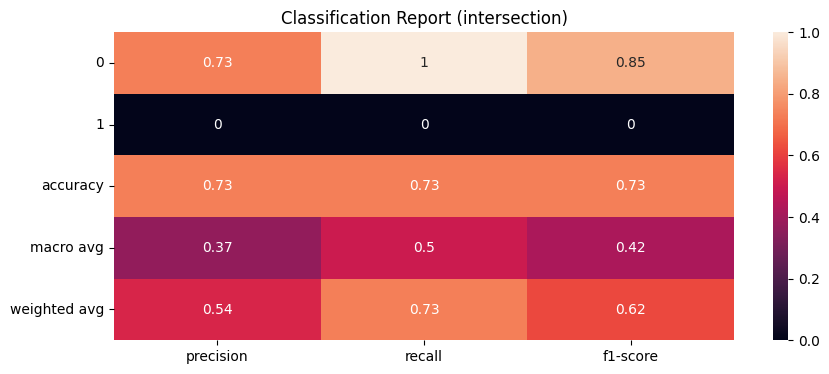

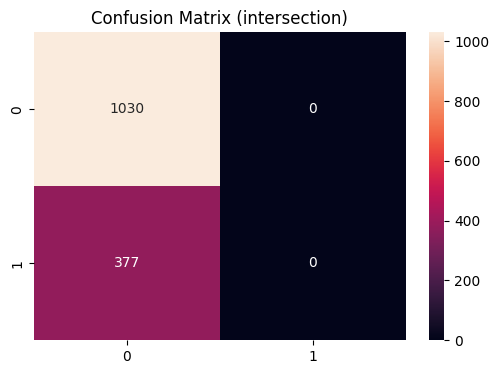

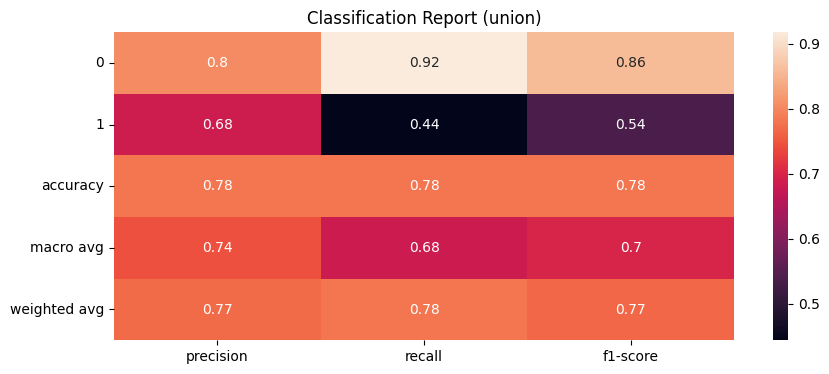

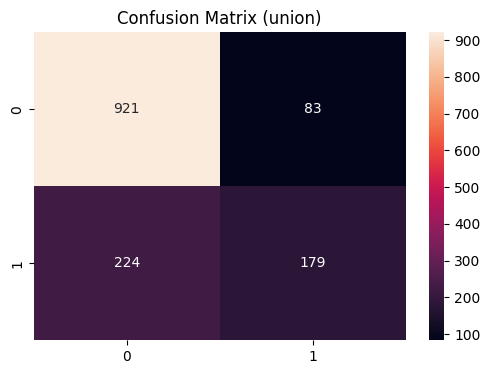

In [8]:
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dotenv import load_dotenv
import os

load_dotenv()  # Загружает переменные из .env
# 1. Проверка переменных окружения
print("Проверка переменных окружения:")
print("AWS_ACCESS_KEY_ID:", "***" if os.getenv("AWS_ACCESS_KEY_ID") else "Не установлен!")
print("AWS_SECRET_ACCESS_KEY:", "***" if os.getenv("AWS_SECRET_ACCESS_KEY") else "Не установлен!")
S3_BUCKET_NAME = os.getenv("S3_BUCKET_NAME", "Не установлен!")

def train_and_log_model(X_train, X_test, y_train, y_test, 
                        experiment_name, model_name, feature_type,run_name):
    
    # Настройка эксперимента
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = mlflow.create_experiment(experiment_name)
    else:
        experiment_id = experiment.experiment_id

    with mlflow.start_run(run_name=run_name, experiment_id=experiment_id) as run:
        run_id = run.info.run_id
        print(run_id)
        print(experiment_id)
        print(mlflow.get_artifact_uri())
        # Инициализация модели
        from catboost import CatBoostClassifier
        model = CatBoostClassifier(
            iterations=500,
            learning_rate=0.1,
            depth=6,
            eval_metric='AUC',
            silent=True
        )
        
        # Обучение модели
        model.fit(X_train, y_train, eval_set=(X_test, y_test))
        print('Model fitted')
        
        # Прогнозирование
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        
        # Вычисление метрик
        auc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        print('Metrics calculated')
        
        # Логирование параметров
        mlflow.log_params({
            "feature_type": feature_type,
            "n_features": X_train.shape[1],
            "model_class": "CatBoostClassifier",
            "test_size": 0.2
        })
        
        # Логирование метрик
        mlflow.log_metrics({
            "ROC-AUC": auc,
            "F1-score": f1
        })
        
        # Генерация и сохранение артефактов
        # 1. Classification Report
        plt.figure(figsize=(10, 4))
        report = classification_report(y_test, y_pred, output_dict=True)
        sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
        plt.title(f"Classification Report ({feature_type})")
        plt.savefig("classification_report.png")
        mlflow.log_artifact("classification_report.png")
        
        # 2. Confusion Matrix
        plt.figure(figsize=(6, 4))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(f"Confusion Matrix ({feature_type})")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        
        # 3. Логирование модели
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.catboost.log_model(
            cb_model=model,
            artifact_path="model",
            signature=signature,
            registered_model_name=model_name
        )

# Обучение и логирование модели на пересечении признаков
train_and_log_model(
    X_train=x_interc_train,
    X_test=x_interc_test,
    y_train=y_interc_train,
    y_test=y_interc_test,
    experiment_name="feature_selection_intersection",
    model_name="churn_intersection_model",
    feature_type="intersection",
    run_name = 'run1'
)

# Обучение и логирование модели на объединении признаков
train_and_log_model(
    X_train=x_union_train,
    X_test=x_union_test,
    y_train=y_union_train,
    y_test=y_union_test,
    experiment_name="feature_selection_union",
    model_name="churn_union_model",
    feature_type="union",
    run_name = 'run2'
)

In [5]:
import os
import boto3
from botocore.client import Config

from dotenv import load_dotenv
import os

load_dotenv()  # Загружает переменные из .env
# 1. Проверка переменных окружения
print("Проверка переменных окружения:")
print("AWS_ACCESS_KEY_ID:", "***" if os.getenv("AWS_ACCESS_KEY_ID") else "Не установлен!")
print("AWS_SECRET_ACCESS_KEY:", "***" if os.getenv("AWS_SECRET_ACCESS_KEY") else "Не установлен!")
S3_BUCKET_NAME = os.getenv("S3_BUCKET_NAME", "Не установлен!")
# 2. Проверка содержимого файла
def check_file(file_path):
    if not os.path.exists(file_path):
        print(f"Файл {file_path} не существует!")
        return False
    if os.path.getsize(file_path) == 0:
        print(f"Файл {file_path} пустой!")
        return False
    print(f"Файл {file_path} существует, размер: {os.path.getsize(file_path)} байт")
    return True

# 3. Пробная загрузка через boto3
def test_s3_upload(bucket, s3_key, local_path):
    try:
        s3 = boto3.client(
            's3',
            endpoint_url='https://storage.yandexcloud.net',
            config=Config(signature_version='s3v4')
        )
        
        s3.upload_file(local_path, bucket, s3_key)
        print(f"Файл успешно загружен в s3://{bucket}/{s3_key}")
        
        # Проверка существования файла
        s3.head_object(Bucket=bucket, Key=s3_key)
        print("Проверка существования: файл найден в S3")
        
    except Exception as e:
        print(f"Ошибка загрузки через boto3: {str(e)}")

# 4. Проверка версий библиотек
print("\nВерсии библиотек:")
import mlflow, boto3
print("MLflow:", mlflow.__version__)
print("Boto3:", boto3.__version__)

# Пример использования
if __name__ == "__main__":
    # Конфигурация
    test_file = "classification_report.png"
    bucket_name = S3_BUCKET_NAME
    s3_key = "test_upload/classification_report.png"
    
    # Запуск проверок
    print("\n[1/3] Проверка файла:")
    check_file(test_file)
    
    print("\n[2/3] Тест загрузки через boto3:")
    test_s3_upload(bucket_name, s3_key, test_file)
    
    print("\n[3/3] Проверка MLflow:")
    print("Tracking URI:", mlflow.get_tracking_uri())

Проверка переменных окружения:
AWS_ACCESS_KEY_ID: ***
AWS_SECRET_ACCESS_KEY: ***

Версии библиотек:
MLflow: 2.7.1
Boto3: 1.34.77

[1/3] Проверка файла:
Файл classification_report.png существует, размер: 27521 байт

[2/3] Тест загрузки через boto3:
Ошибка загрузки через boto3: Failed to upload classification_report.png to s3-student-mle-20240824-ff21c1bdfa/test_upload/classification_report.png: An error occurred (SignatureDoesNotMatch) when calling the PutObject operation: The request signature we calculated does not match the signature you provided. Check your key and signing method.

[3/3] Проверка MLflow:
Tracking URI: http://127.0.0.1:5000


Проверка переменных окружения:
AWS_ACCESS_KEY_ID: ***
AWS_SECRET_ACCESS_KEY: ***
a63fd5e9830944abb0bcc573343426d6
1
s3://s3-student-mle-20240824-ff21c1bdfa/1/a63fd5e9830944abb0bcc573343426d6/artifacts
Model fitted
Metrics calculated


/home/mle-user/mle_projects/mle-mlflow/.new_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mle-user/mle_projects/mle-mlflow/.new_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mle-user/mle_projects/mle-mlflow/.new_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

612881b0b1564d7ba6870fd033d7925e
3
s3://s3-student-mle-20240824-ff21c1bdfa/3/612881b0b1564d7ba6870fd033d7925e/artifacts
Model fitted
Metrics calculated


Registered model 'churn_intersection_union_model' already exists. Creating a new version of this model...
2025/02/06 11:44:21 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: churn_intersection_union_model, version 2
Created version '2' of model 'churn_intersection_union_model'.


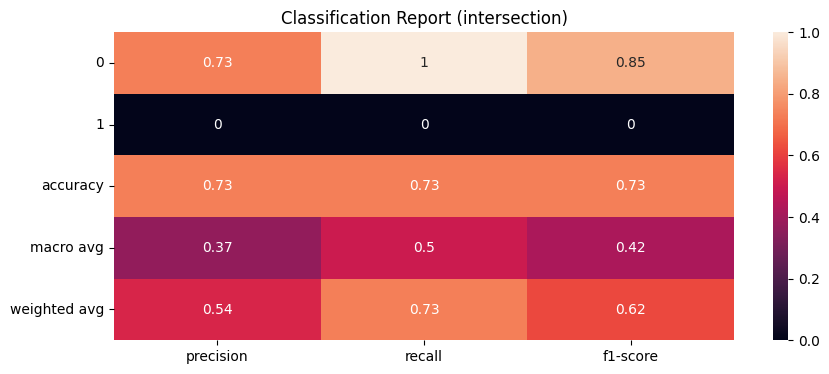

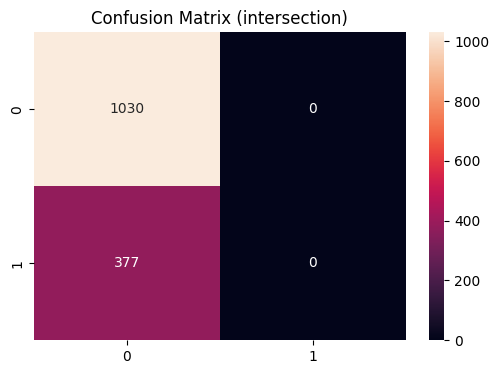

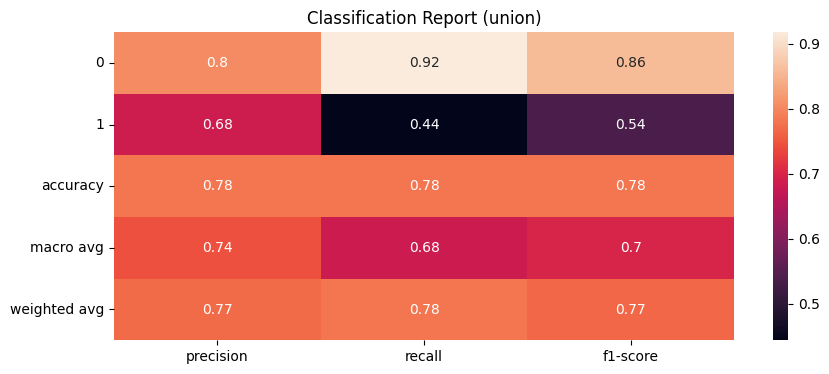

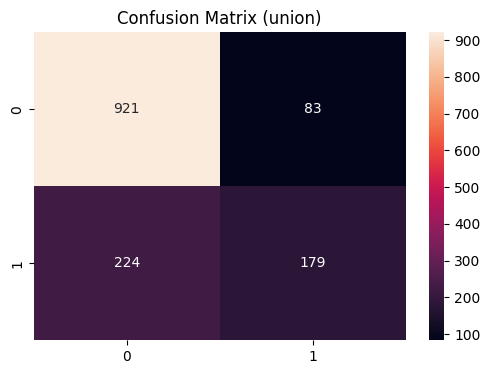

In [9]:
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dotenv import load_dotenv
import os

load_dotenv()  # Загружает переменные из .env
# 1. Проверка переменных окружения
print("Проверка переменных окружения:")
print("AWS_ACCESS_KEY_ID:", "***" if os.getenv("AWS_ACCESS_KEY_ID") else "Не установлен!")
print("AWS_SECRET_ACCESS_KEY:", "***" if os.getenv("AWS_SECRET_ACCESS_KEY") else "Не установлен!")
S3_BUCKET_NAME = os.getenv("S3_BUCKET_NAME", "Не установлен!")

def train_and_log_model(X_train, X_test, y_train, y_test, 
                        experiment_name, model_name, feature_type, run_name):
    
    # Настройка эксперимента
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        experiment_id = mlflow.create_experiment(experiment_name)
    else:
        experiment_id = experiment.experiment_id

    with mlflow.start_run(run_name=run_name, experiment_id=experiment_id) as run:
        run_id = run.info.run_id
        print(run_id)
        print(experiment_id)
        print(mlflow.get_artifact_uri())
        # Инициализация модели
        from catboost import CatBoostClassifier
        model = CatBoostClassifier(
            iterations=500,
            learning_rate=0.1,
            depth=6,
            eval_metric='AUC',
            silent=True
        )
        
        # Обучение модели
        model.fit(X_train, y_train, eval_set=(X_test, y_test))
        print('Model fitted')
        
        # Прогнозирование
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        
        # Вычисление метрик
        auc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        print('Metrics calculated')
        
        # Логирование параметров
        mlflow.log_params({
            "feature_type": feature_type,
            "n_features": X_train.shape[1],
            "model_class": "CatBoostClassifier",
            "test_size": 0.2
        })
        
        # Логирование метрик
        mlflow.log_metrics({
            "ROC-AUC": auc,
            "F1-score": f1
        })
        
        # Генерация и сохранение артефактов
        # 1. Classification Report
        plt.figure(figsize=(10, 4))
        report = classification_report(y_test, y_pred, output_dict=True)
        sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
        plt.title(f"Classification Report ({feature_type})")
        plt.savefig("classification_report.png")
        mlflow.log_artifact("classification_report.png")
        
        # 2. Confusion Matrix
        plt.figure(figsize=(6, 4))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(f"Confusion Matrix ({feature_type})")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        
        # 3. Логирование модели
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.catboost.log_model(
            cb_model=model,
            artifact_path="model",
            signature=signature,
            registered_model_name=model_name
        )

# Обучение и логирование модели на пересечении признаков
train_and_log_model(
    X_train=x_interc_train,
    X_test=x_interc_test,
    y_train=y_interc_train,
    y_test=y_interc_test,
    experiment_name="feature_selection_intersection",
    model_name="churn_intersection_union_model",
    feature_type="intersection",
    run_name='run1'
)

# Обучение и логирование модели на объединении признаков
train_and_log_model(
    X_train=x_union_train,
    X_test=x_union_test,
    y_train=y_union_train,
    y_test=y_union_test,
    experiment_name="feature_selection_union",
    model_name="churn_intersection_union_model",
    feature_type="union",
    run_name='run2'
)

In [17]:
X = pd.read_csv('data/X_autofeat.csv')
y = pd.read_csv('data/y_autofeat.csv')

In [18]:
X

,monthly_charges,total_charges,paperless_billing_No,paperless_billing_Yes,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_DSL,internet_service_Fiber optic,...,gender_Female,gender_Male,senior_citizen_0,senior_citizen_1,partner_No,partner_Yes,dependents_No,dependents_Yes,multiple_lines_No,multiple_lines_Yes
0,0.738308,0.740994,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.854726,0.885201,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.990547,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0.893532,0.866992,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.899005,0.885310,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.256716,0.002914,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7028,0.009950,0.000052,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
7029,0.271642,0.003087,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7030,0.264179,0.003000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [23]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    confusion_matrix,
)
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv



TABLE_NAME = 'users_churn'

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'churn_prediction_experiment'
RUN_NAME = 'model_grid_search' 
REGISTRY_MODEL_NAME = 'churn_intersection_union_model'

features = ["monthly_charges", "total_charges", "senior_citizen_0",	"senior_citizen_1"]
target = "target"

# split_column = "date_column"  # Колонка для разделения данных (например, дата)
stratify_column = "target"  # Колонка для стратификации
test_size = 0.2  # Размер тестовой выборки

# df = df.sort_values(by=[split_column])

X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=test_size, shuffle=False)

print(f"Размер выборки для обучения: {X_train.shape}")
print(f"Размер выборки для теста: {X_test.shape}")

loss_function = "Logloss"
task_type = 'CPU'
random_seed = 0
iterations = 300
verbose = False

params = {
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1, 0.2],
    "l2_leaf_reg": [1, 3, 5]
}

# Модель CatBoost
model = CatBoostClassifier(
    loss_function=loss_function,
    task_type=task_type,
    random_seed=random_seed,
    iterations=iterations,
    verbose=verbose
)

cv = GridSearchCV(model, params, cv=2, scoring='roc_auc', n_jobs=-1)

clf = cv.fit(X_train, y_train)

        
        

Размер выборки для обучения: (5625, 4)
Размер выборки для теста: (1407, 4)


In [26]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()
import mlflow

TABLE_NAME = 'users_churn'

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'churn_volkovandrey_test'
RUN_NAME = 'model_grid_search' 
REGISTRY_MODEL_NAME = 'churn_intersection_union_model'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

cv_results = pd.DataFrame(clf.cv_results_)

best_params = clf.best_params_

model_best = CatBoostClassifier(
    **best_params,
    loss_function=loss_function,
    task_type=task_type,
    random_seed=random_seed,
    iterations=iterations,
    verbose=verbose
)

model_best.fit(X_train, y_train)

prediction = model_best.predict(X_test)
probas = model_best.predict_proba(X_test)[:, 1]

# расчёт метрик качества
metrics = {}

_, err1, _, err2 = confusion_matrix(y_test, prediction, normalize='all').ravel()
auc = roc_auc_score(y_test, probas)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)
logloss = log_loss(y_test, prediction)

# сохранение метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

# дополнительные метрики из результатов кросс-валидации
metrics["mean_fit_time"] = cv_results["mean_fit_time"].mean()
metrics['std_fit_time'] = cv_results['std_fit_time'].mean()
metrics["mean_test_score"] = cv_results["mean_test_score"].mean()
metrics['std_test_score'] = cv_results['std_test_score'].mean()
metrics['best_score'] = clf.best_score_

# настройки для логирования в MLFlow
pip_requirements = 'requirements.txt'
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_test[:10]

# Создание эксперимента
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    # Логирование параметров
    mlflow.log_params(best_params)
    
    # Логирование метрик
    mlflow.log_metrics(metrics)
    
    # Логирование модели
    cv_info = mlflow.sklearn.log_model(cv, artifact_path='cv')
    model_info = mlflow.catboost.log_model(
        cb_model=model_best,
        artifact_path='models',
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        await_registration_for=60,
        pip_requirements=pip_requirements)

Registered model 'churn_intersection_union_model' already exists. Creating a new version of this model...
2025/02/19 18:59:39 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_intersection_union_model, version 3
Created version '3' of model 'churn_intersection_union_model'.


In [30]:
from sklearn.model_selection import RandomizedSearchCV

TABLE_NAME = 'users_churn'
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = 'churn_volkovandrey_test'
RUN_NAME = 'model_random_search'
REGISTRY_MODEL_NAME = 'churn_intersection_union_model'

# # Фичи и целевая переменная
# features = ["monthly_charges", "total_charges", "senior_citizen"]
# target = "target"

# # Настройки для разделения данных
# split_column = "date_column"  # Колонка для разделения данных (например, дата)
# stratify_column = "target"  # Колонка для стратификации
# test_size = 0.2  # Размер тестовой выборки

# # Загрузка данных
# df = pd.read_csv(TABLE_NAME)  # Замените на ваш способ загрузки данных
# df = df.sort_values(by=[split_column])

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X[features], y, test_size=test_size, shuffle=False
)

print(f"Размер выборки для обучения: {X_train.shape}")
print(f"Размер выборки для теста: {X_test.shape}")

# Параметры модели
loss_function = "Logloss"
task_type = 'CPU'
random_seed = 0
iterations = 300
verbose = False

# Сетка гиперпараметров для RandomizedSearchCV
params = {
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1, 0.2],
    "l2_leaf_reg": [1, 3, 5]
}

# Модель CatBoost
model = CatBoostClassifier(
    loss_function=loss_function,
    task_type=task_type,
    random_seed=random_seed,
    iterations=iterations,
    verbose=verbose
)

# RandomizedSearchCV
cv = RandomizedSearchCV(
    model, params,  n_iter=20, cv=2, scoring='roc_auc', random_state=random_seed, n_jobs=-1
)

# Обучение модели с поиском гиперпараметров
clf = cv.fit(X_train, y_train)

# # Настройка MLflow
# os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
# os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("S3_ACCESS_KEY")
# os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("S3_SECRET_KEY")

# mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
# mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# Результаты кросс-валидации
cv_results = pd.DataFrame(clf.cv_results_)

# Лучшие параметры
best_params = clf.best_params_

# Модель с лучшими параметрами
model = CatBoostClassifier(
    **best_params,
    loss_function=loss_function,
    task_type=task_type,
    random_seed=random_seed,
    iterations=iterations,
    verbose=verbose
)

# Обучение лучшей модели
model_best.fit(X_train, y_train)

# Предсказания
prediction = model_best.predict(X_test)
probas = model_best.predict_proba(X_test)[:, 1]

# Расчёт метрик качества
metrics = {}

# Ошибки первого и второго рода
_, err1, _, err2 = confusion_matrix(y_test, prediction, normalize='all').ravel()
auc = roc_auc_score(y_test, probas)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)
logloss = log_loss(y_test, prediction)

# Сохранение метрик в словарь
metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

# Дополнительные метрики из результатов кросс-валидации
metrics["mean_fit_time"] = cv_results["mean_fit_time"].mean()
metrics["std_fit_time"] = cv_results["std_fit_time"].mean()
metrics["mean_test_score"] = cv_results["mean_test_score"].mean()
metrics["std_test_score"] = cv_results["std_test_score"].mean()
metrics["best_score"] = clf.best_score_



Размер выборки для обучения: (5625, 4)
Размер выборки для теста: (1407, 4)


In [31]:
# Настройки для логирования в MLFlow
# pip_requirements = 'requirements.txt'
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_test[:10]  # Пример входных данных

# Создание эксперимента
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

# Логирование в MLflow
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    # Логирование параметров
    mlflow.log_params(best_params)
    
    # Логирование метрик
    mlflow.log_metrics(metrics)
    
    # Логирование модели
    cv_info = mlflow.sklearn.log_model(cv, artifact_path='cv')
    model_info = mlflow.catboost.log_model(
        cb_model=model_best,
        artifact_path='models',
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        await_registration_for=60,
        pip_requirements=pip_requirements
    )

Registered model 'churn_intersection_union_model' already exists. Creating a new version of this model...
2025/02/19 19:15:23 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_intersection_union_model, version 4
Created version '4' of model 'churn_intersection_union_model'.
